# Does Oil Well Production Decrease with Age?

In this notebook, we explore the relationship between the age of an oil well and its output.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import zipfile
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Opens zip file and creates data directory
# If files get large, will need to check to see if exists, and only replace new ones (or updates)
#zip_ref = zipfile.ZipFile('./data.zip', 'r')
#zip_ref.extractall('./')
#zip_ref.close()

In [56]:
# set some plot defaults
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [5]:
# function to calculate the number of months between a data and an array of dates
def months_since(dateto, datesfrom):
    m = [(dateto.year - d.year) * 12 + (dateto.month - d.month) for d in datesfrom]
    return np.array(m)

In [6]:
# read up the well data:
WellData_Raw = pd.read_csv("./data/welldata/WellData.csv",low_memory=False)

# get rid of the dup API nummber records by taking first in group
DimWell = WellData_Raw.groupby('API_num').first()

# ditch the wells for which there's no longitude or latitude:
DimWell.dropna(axis=0, how='any', subset=['long','lat'],inplace=True)

# fix up the completion date:
DimWell['complete_date'] = pd.to_datetime(DimWell['complete_date'])

#Age in months calculated from completion date:
DimWell['AgeMonths'] = months_since(datetime.datetime.today(),DimWell.complete_date)

In [7]:
def makeapinum(cnty, seq, sidetrack, st='05'):
    APInum = st + '-' + str(cnty).zfill(3) + '-' + str(seq).zfill(5) + '-' + \
                                            str(sidetrack).zfill(2)
    return APInum

In [8]:
# read up the production data
ProductionData_Raw = pd.read_csv("./data/welldata/Production.csv", low_memory=False)

# tack on an API code:
ProductionData_Raw['API_num'] = ProductionData_Raw.apply(lambda c:makeapinum(c.api_county_code, c.api_seq_num, c.sidetrack_num), axis=1)

# sum up the production data for each well:
FactProduction = ProductionData_Raw[['API_num','Prod_days','oil_prod']].groupby('API_num').sum()

# ditch the records for which there's no production data:
FactProduction.dropna(axis=0, how='any',inplace=True)

# join the Well data to the produciton data:
dimcols = ['long','lat', 'formation_code', 'complete_date','AgeMonths']
oil_df = FactProduction.merge(DimWell[dimcols], left_index=True, right_index=True)
oil_df['BblPerDay'] = oil_df.oil_prod/oil_df.Prod_days

# ditch the records before 1970
oil_df = oil_df.query('complete_date >= \'1/1/1970\'')

In [9]:
oil_df.head()

,Prod_days,oil_prod,long,lat,formation_code,complete_date,AgeMonths,BblPerDay
API_num,,,,,,,,
05-001-05542-00,34.0,37.0,-103.818583,39.981528,DSND,1985-03-06,396.0,1.088235
05-001-06007-00,244.0,172.0,-104.274980,39.874660,DSND,1981-08-22,439.0,0.704918
05-001-06072-00,206.0,58.0,-104.124690,39.944300,JSND,2004-09-30,162.0,0.281553
05-001-06121-00,351.0,602.0,-104.581070,39.857200,JSND,2012-04-25,71.0,1.715100
05-001-06137-00,328.0,259.0,-104.120310,39.897676,JSND,1988-09-15,354.0,0.789634


In [10]:
print('number of oil wells: %d, wells missing complete dates: %d' % (len(oil_df),oil_df.complete_date.isnull().sum()))

number of oil wells: 30060, wells missing complete dates: 0


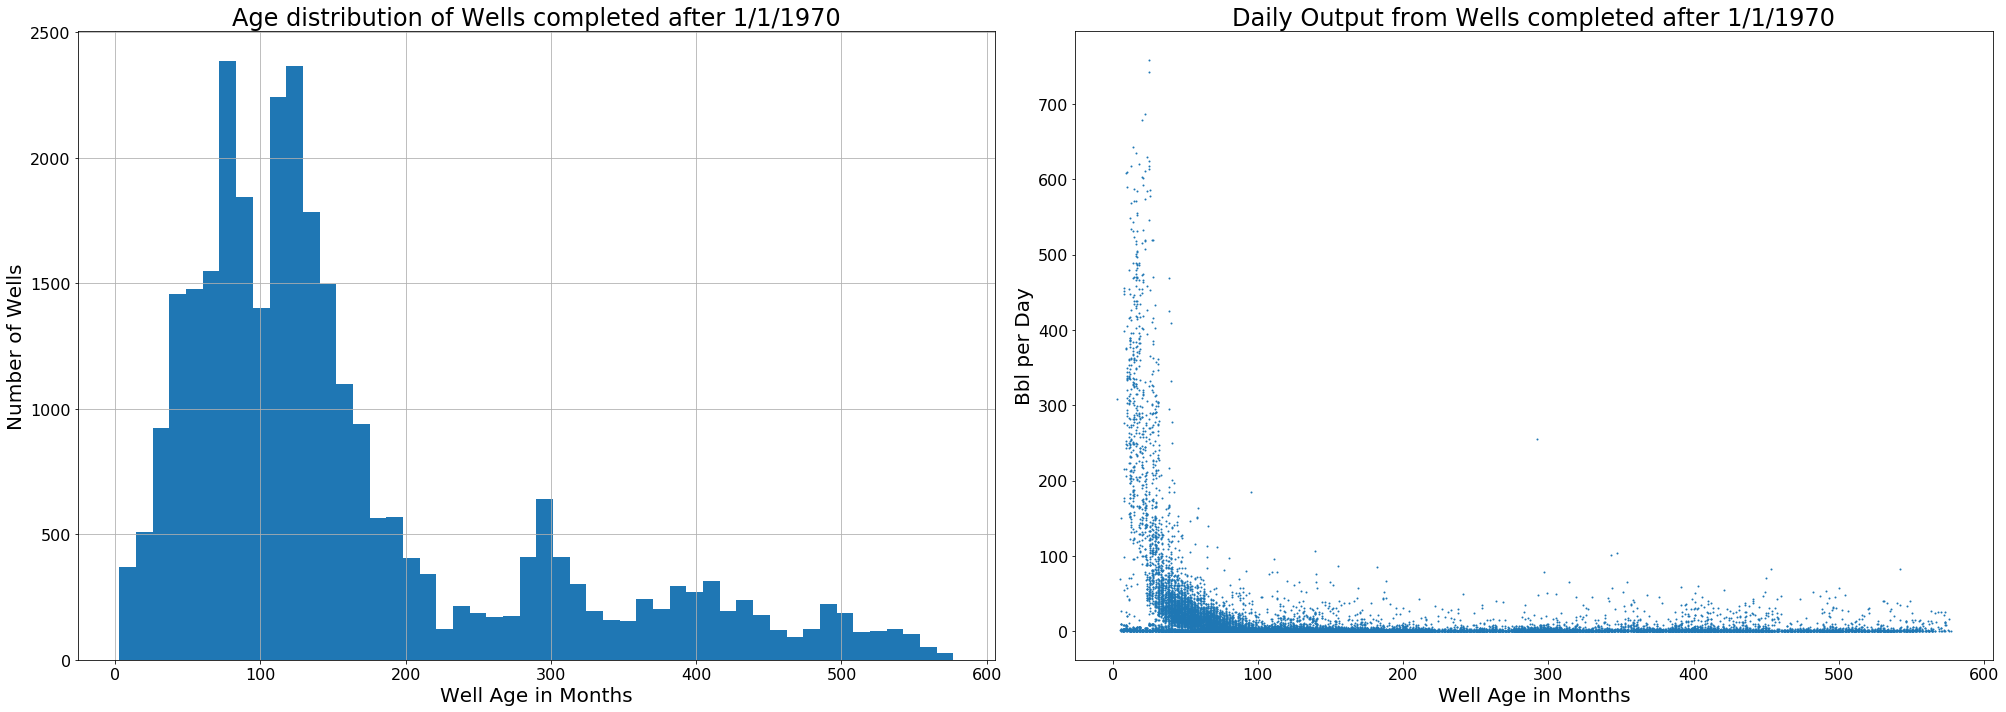

In [11]:
f = plt.figure(figsize=(28,10))
ax = plt.subplot(1,2,1)

oil_df.hist('AgeMonths',bins=50, ax=ax)
plt.title('Age distribution of Wells completed after 1/1/1970')
plt.ylabel('Number of Wells')
plt.xlabel('Well Age in Months')

ax = plt.subplot(1,2,2)
plt.scatter(oil_df.AgeMonths, oil_df.BblPerDay, s=1)
plt.title('Daily Output from Wells completed after 1/1/1970')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.tight_layout()

In [28]:
# calculate median value for each age
prod_med = oil_df.groupby('AgeMonths').median().BblPerDay
prod_med.head()

AgeMonths
3.0    307.737705
5.0     35.774194
6.0      2.555556
7.0      1.835443
8.0      2.647541
Name: BblPerDay, dtype: float64

In [34]:
#first two points look anomalous, so zero them out!!
prod_med.iloc[0:2] = 0
prod_med.head()

AgeMonths
3.0    0.000000
5.0    0.000000
6.0    2.555556
7.0    1.835443
8.0    2.647541
Name: BblPerDay, dtype: float64

In [47]:
# smooth the medians by fitting a spline
from scipy.interpolate import spline
xnew = np.linspace(prod_med.min(),prod_med.max(),200) #represents number of points to make between T.min and T.max
prod_med_smooth = spline(prod_med.index,prod_med.values,xnew)

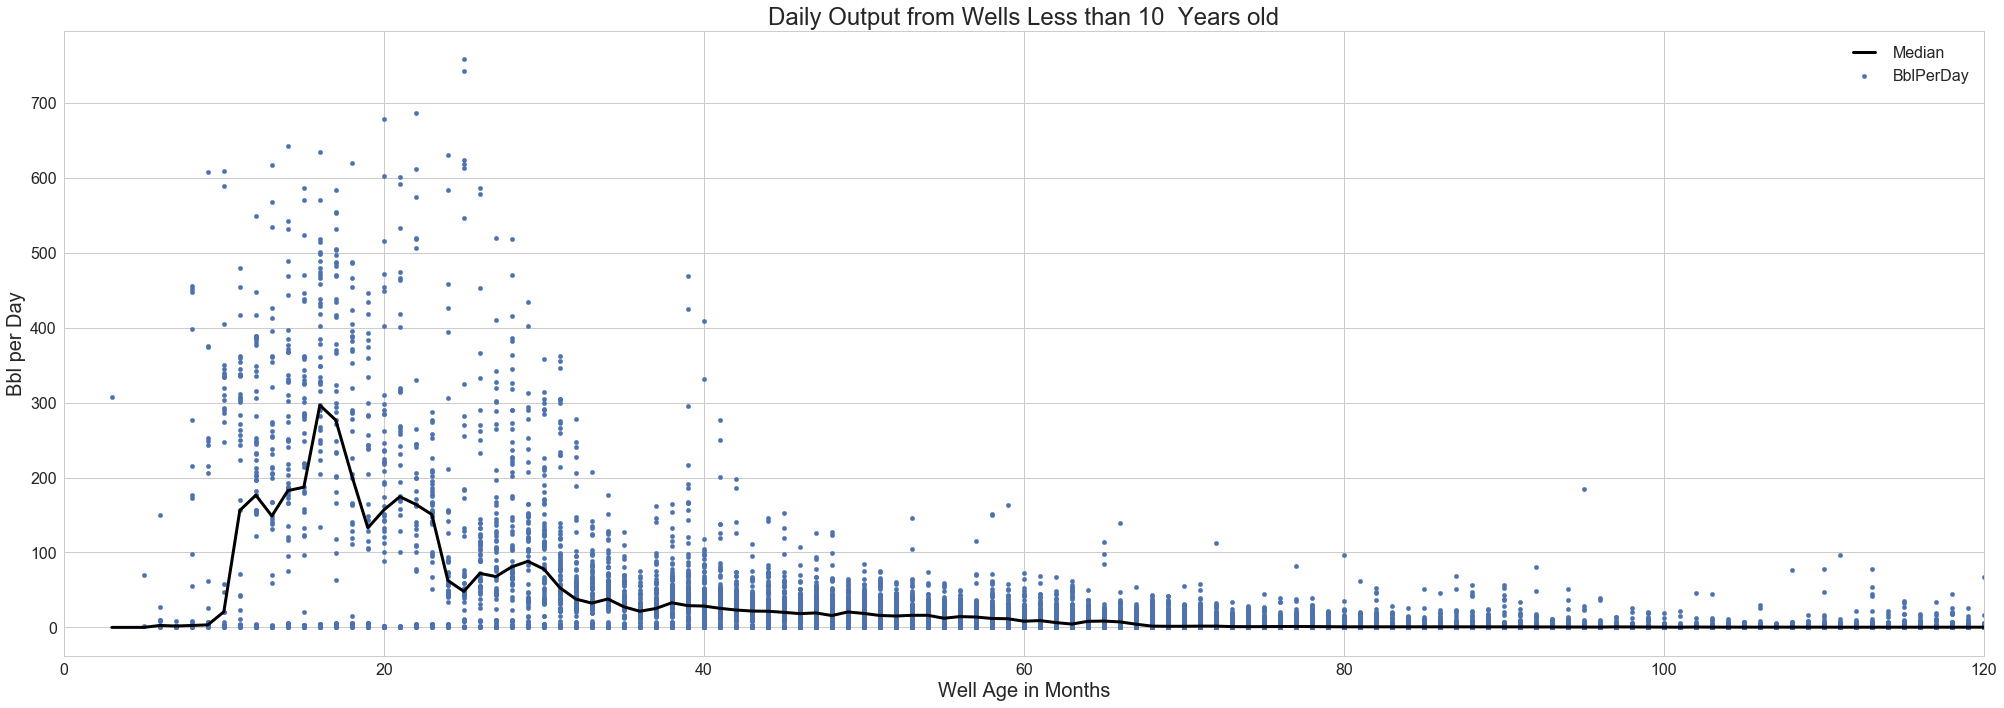

In [66]:
f = plt.figure(figsize=(28,10))
ax = plt.subplot()
ax.set_xlim(0,120)
plt.scatter(oil_df.AgeMonths, oil_df.BblPerDay, s=20)
plt.title('Daily Output from Wells Less than 10  Years old')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.plot(prod_med.index, prod_med.values,color='black',label='Median')
plt.legend(numpoints=2,fontsize=16,markerscale=1, facecolor="white",framealpha=1)
plt.tight_layout()